In [ ]:
%load_ext autoreload
%autoreload 2

In [2]:
!eotdl version

EOTDL Version: 2025.05.26-4


# Dataset

The dataset used for this use case is extracted from the dataset deveolped in use case A, which can be found at https://www.eotdl.com/datasets/SatellogicDataset

In [1]:
!eotdl datasets get SatellogicDataset -p data -a -f

Staging assets: 100%|█████████████████████████████| 3/3 [00:08<00:00,  2.88s/it]
Data available at data/SatellogicDataset


The dataset contains a list of HR Satelligic images with Sentinel 1 and Sentinel 2 matches. For this use case, we are only interested in the Sentinel 2 images since we want to create a superresolution dataset to artificially create a HR Sentinel 2 image from a LR Sentinel 2 image, using the Satellogic HR image as target.

In [2]:
import geopandas as gpd

gdf = gpd.read_parquet('data/SatellogicDataset/satellogic-earthview-items-with-matches-1M.parquet')

gdf.head()

,json_path,zone,region,date,geometry,s2_matches,s1_matches
6292276,data/json/zone=51S/region=357067_6579845/date=...,51S,357067_6579845,2022-10-26,"POLYGON ((121.50829 -30.90962, 121.50835 -30.9...",[{'id': 'S2A_MSIL2A_20221101T015631_N0400_R117...,[]
5793006,data/json/zone=46N/region=374867_2457086/date=...,46N,374867_2457086,2022-12-25,"POLYGON ((91.7897 22.2112, 91.78967 22.21467, ...",[{'id': 'S2B_MSIL2A_20230103T042149_N0509_R090...,[{'id': 'S1A_IW_GRDH_1SDV_20221230T120414_2022...
3933716,data/json/zone=38N/region=601805_4299370/date=...,38N,601805_4299370,2022-10-05,"POLYGON ((46.17736 38.83375, 46.17741 38.83721...",[{'id': 'S2B_MSIL2A_20221015T073859_N0400_R092...,[{'id': 'S1A_IW_GRDH_1SDV_20221011T145333_2022...
1746111,data/json/zone=20S/region=598796_7170926/date=...,20S,598796_7170926,2022-09-03,"POLYGON ((-62.01249 -25.57924, -62.01252 -25.5...",[{'id': 'S2A_MSIL2A_20220911T140721_N0400_R110...,[]
6011504,data/json/zone=50N/region=698978_4416263/date=...,50N,698978_4416263,2022-09-04,"POLYGON ((119.33101 39.86955, 119.33112 39.873...",[{'id': 'S2A_MSIL2A_20220913T024541_N0400_R132...,[]


We use the script `download_images.py` to download the Sentinel 2 and Satellogic images from the dataset.

Once the data is downloaded, you will have a list of Satellogic HR images with Sentinel 2 matches.

In [3]:
from glob import glob
path = '/fastdata/Satellogic/data/tifs'

s2_images = glob(path + '/sentinel2/*.tiff')
satellogic_hr_images  = [i.replace('_S2L2A.tiff', '_TOA.tif').replace('/sentinel2/', '/satellogic/') for i in s2_images]

len(satellogic_hr_images)

260177

Warning 1: TIFFReadDirectory:Sum of Photometric type-related color channels and ExtraSamples doesn't match SamplesPerPixel. Defining non-color channels as ExtraSamples.
Warning 1: TIFFReadDirectory:Sum of Photometric type-related color channels and ExtraSamples doesn't match SamplesPerPixel. Defining non-color channels as ExtraSamples.
Warning 1: TIFFReadDirectory:Sum of Photometric type-related color channels and ExtraSamples doesn't match SamplesPerPixel. Defining non-color channels as ExtraSamples.
Warning 1: TIFFReadDirectory:Sum of Photometric type-related color channels and ExtraSamples doesn't match SamplesPerPixel. Defining non-color channels as ExtraSamples.
Warning 1: TIFFReadDirectory:Sum of Photometric type-related color channels and ExtraSamples doesn't match SamplesPerPixel. Defining non-color channels as ExtraSamples.


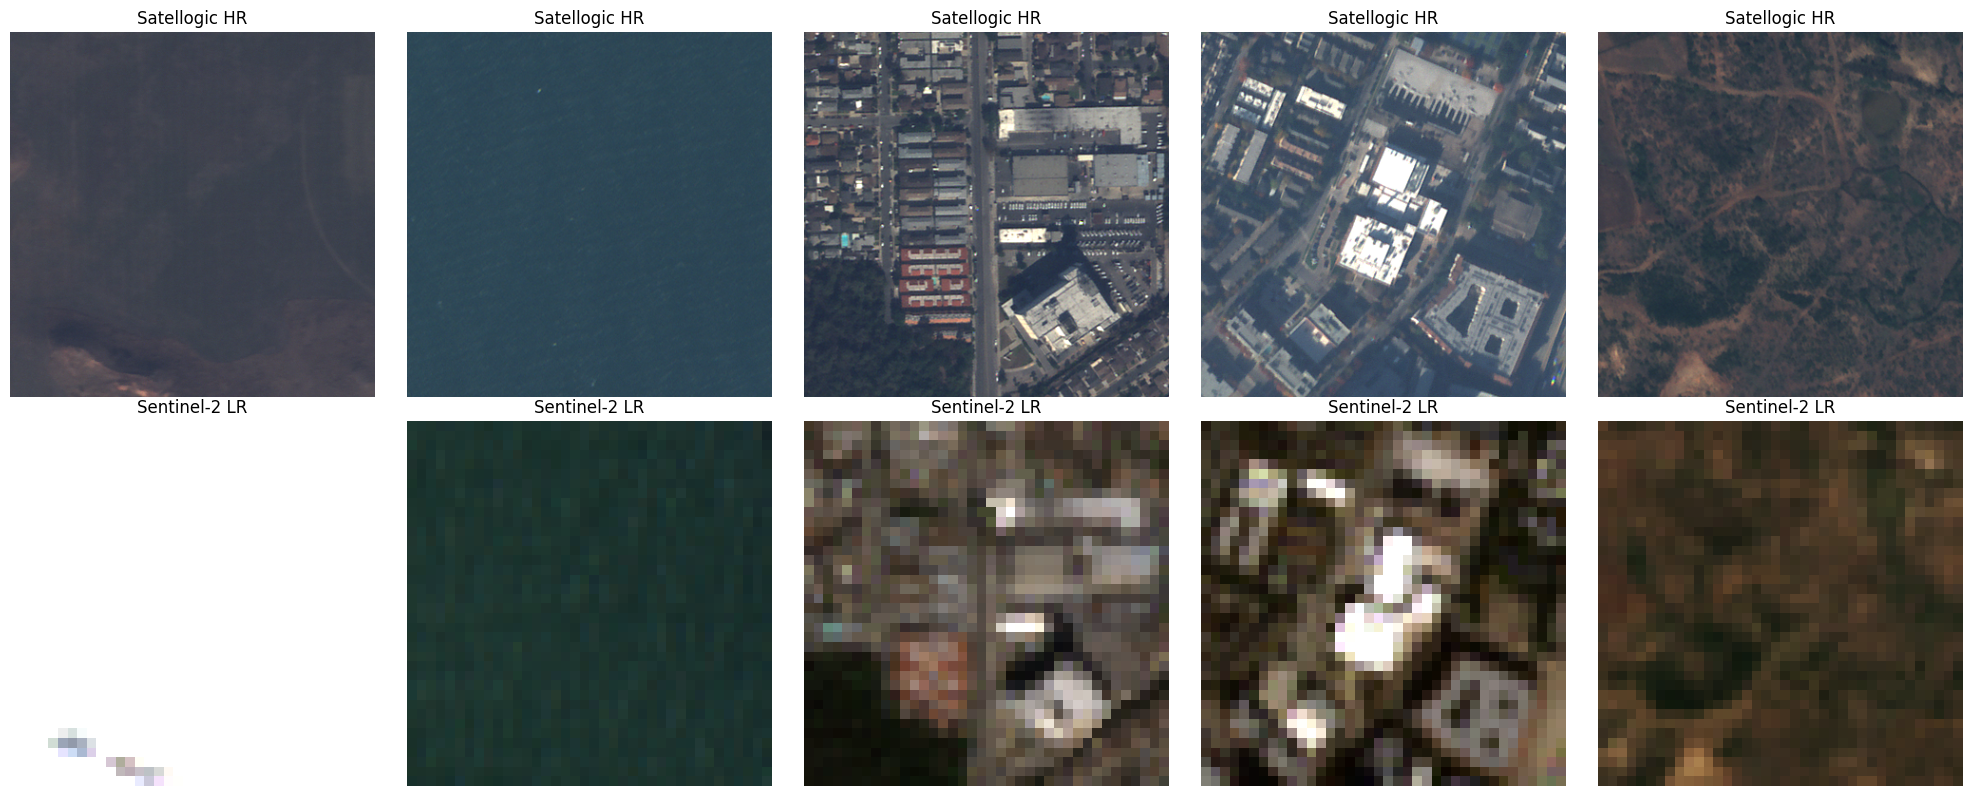

In [8]:
import matplotlib.pyplot as plt
import rasterio as rio
import random

# Create a figure with 2 rows and 5 columns
fig, axes = plt.subplots(2, 5, figsize=(20, 8))

# Plot first 5 pairs of images
for i in range(5):
    ix = random.randint(0, len(satellogic_hr_images))
    # Load and plot Satellogic image
    x = rio.open(satellogic_hr_images[ix]).read((1,2,3)) / 4000
    axes[0,i].imshow(x.transpose(1,2,0).clip(0,1))
    axes[0,i].set_title('Satellogic HR')
    axes[0,i].axis('off')
    # Load and plot Sentinel-2 image (38x38 center crop to match the Satellogic HR image)
    x = rio.open(s2_images[ix]).read((4,3,2)) / 4000
    h, w = x.shape[1:]
    x = x[:, h//2-19:h//2+19, w//2-19:w//2+19]
    axes[1,i].imshow(x.transpose(1,2,0).clip(0,1))
    axes[1,i].set_title('Sentinel-2 LR')
    axes[1,i].axis('off')       

plt.tight_layout()
plt.show()
